In [2]:
import pickle

In [3]:
with open('../data/pickled_data/AEK201_short.pkl', 'rb') as f:
    df = pickle.load(f)


In [3]:
df = df[['date', 'avg_well_depth', 'gage_ht', 'discharge_cfs', 'prcp',
       'temp_avg', 'temp_max', 'temp_min', 'hPa_avg', 'hum_avg', 'hum_max',
       'hum_min', 'wind_avg', 'wind_max', 'wind_min', 'gust_avg', 'gust_max',
       'gust_min']]

In [4]:
## Following the tutorial outlined here:
## https://www.tensorflow.org/tutorials/structured_data/time_series
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [5]:
date_time = pd.to_datetime(df.pop('date'), format='%d.%m.%Y %H:%M:%S')

Lets vizualize the evolution of a few features of time:

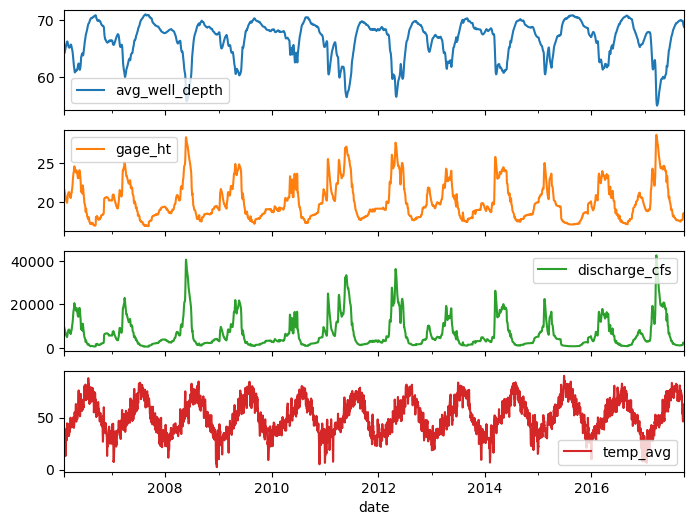

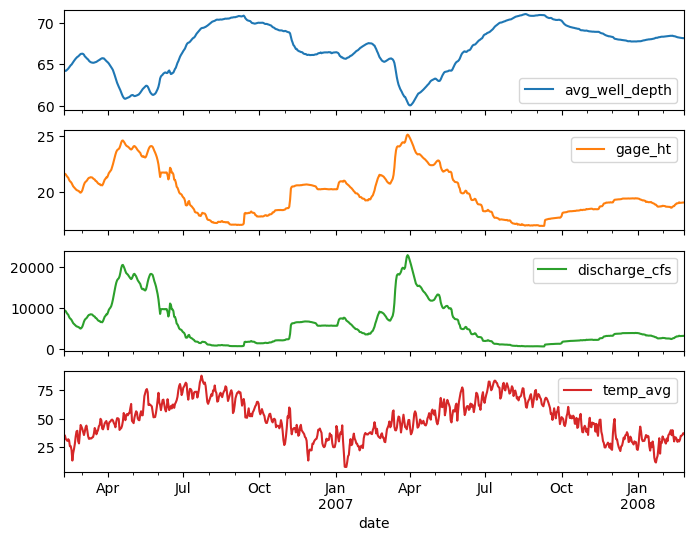

In [6]:
plot_cols = ['avg_well_depth', 'gage_ht', 'discharge_cfs', 'temp_avg']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:750]
plot_features.index = date_time[:750]
_ = plot_features.plot(subplots=True)

## Inspection and Cleanup

Lets look at the summary statistics for our dataset.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
avg_well_depth,4252.0,66.580739,3.325407,54.990211,64.822188,67.602048,69.064896,71.077083
gage_ht,4252.0,20.147778,2.380274,16.950000,18.310000,19.420000,21.380000,28.680000
discharge_cfs,4252.0,6753.141345,7013.195318,539.000000,1960.000000,3830.000000,8612.500000,42600.000000
prcp,4252.0,0.045085,0.113413,0.000000,0.000000,0.000000,0.020000,1.330000
temp_avg,4252.0,50.677112,16.546918,2.323704,37.767917,49.529583,64.353646,90.079167
temp_max,4252.0,60.092119,19.779527,8.110000,44.130000,58.440000,76.570000,106.630000
temp_min,4252.0,41.646082,13.758471,-6.020000,31.910000,41.375000,52.560000,79.140000
hPa_avg,4252.0,1015.875325,6.903473,988.875000,1011.580645,1015.291667,1019.833333,1042.208333
hum_avg,4252.0,62.602109,18.773511,19.041667,46.208333,63.291667,79.712258,96.666667
hum_max,4252.0,81.447789,13.421224,35.000000,73.000000,85.500000,92.000000,100.000000


That maximum value for `gust_min` seems pretty high.

The minimum wind gust measurment should be the lowest gust speed reported in any hour of the given day. For a value to be as high as 21.9 mph, every other hour of that day would have a gust speed greater than that. Thats a very windy day. Lets look and see what's up.

In [8]:
df.loc[df.gust_min>0]

,avg_well_depth,gage_ht,discharge_cfs,prcp,temp_avg,temp_max,temp_min,hPa_avg,hum_avg,hum_max,hum_min,wind_avg,wind_max,wind_min,gust_avg,gust_max,gust_min
39123,68.304167,19.07,3170.0,0.34,36.844483,41.07,30.74,1005.103448,74.896552,87.0,54.0,22.594138,28.86,14.99,31.702069,40.26,21.92
39124,68.199583,19.21,3420.0,1.18,45.420000,50.63,39.65,1010.960000,81.880000,86.0,76.0,18.798800,24.16,13.87,27.138000,33.33,20.80


Okay, it seems pretty odd that only teo values would be non-zero in the whole dataset. We'll just drop that column.

In [9]:
df = df.drop(['gust_min'], axis=1)

## Feature Engineering

### Establishing Frequency
We suspect that the frequency that is important to us is annual, and we can verify this by using a Fast Fourier transform to extract this informtiaion using the [tf.signal.rfft](https://www.tensorflow.org/api_docs/python/tf/signal/rfft) package.

We'll look at the FFT of `avg_well_depth` and `prcp` over time:

2023-11-01 16:34:09.844747: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-11-01 16:34:09.844770: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-11-01 16:34:09.844776: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-11-01 16:34:09.844808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-01 16:34:09.844823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


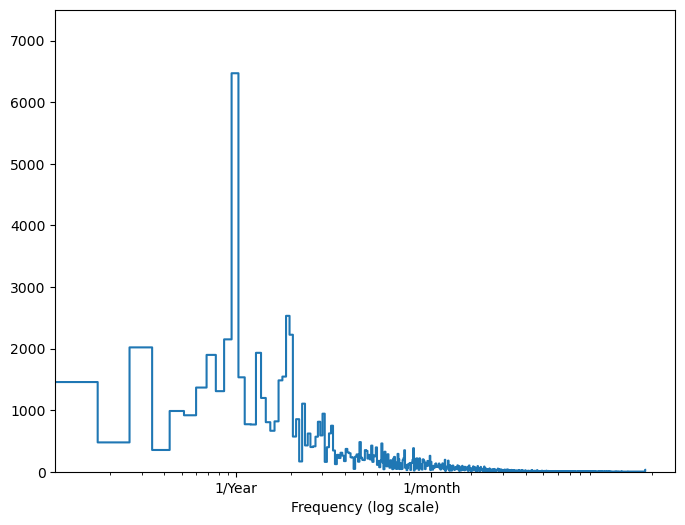

In [10]:
data = df.avg_well_depth.values
fft = tf.signal.rfft(data)
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(data)
days_per_year = 365
years_per_dataset = n_samples_d/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 7500)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 12], labels=['1/Year', '1/month'])
_ = plt.xlabel('Frequency (log scale)')

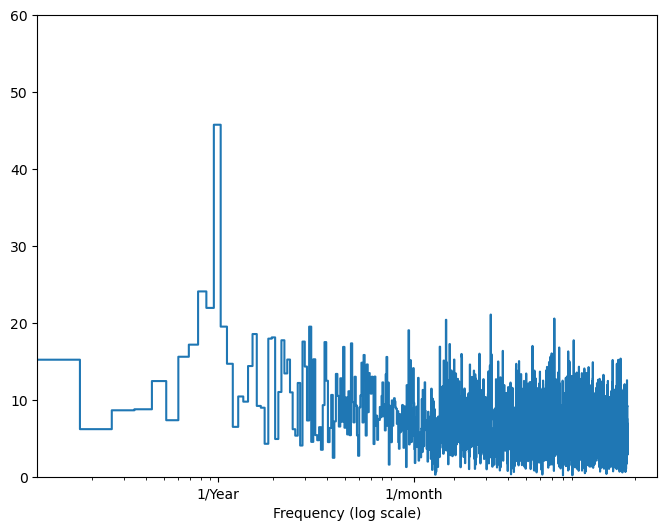

In [11]:
data = df.prcp.values
fft = tf.signal.rfft(data)
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(data)
days_per_year = 365
years_per_dataset = n_samples_d/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 60)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 12], labels=['1/Year', '1/month'])
_ = plt.xlabel('Frequency (log scale)')

Our suspicion that the frequency of our data is annual appears to be supported by these graphs. We'll procede under that assumption.

### Time

Right now, we have time in days as a timestamp. It could be helpful to transform this into a sine or cosine function to get "time of year" signals.

In [12]:
## Convert timestamp to seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

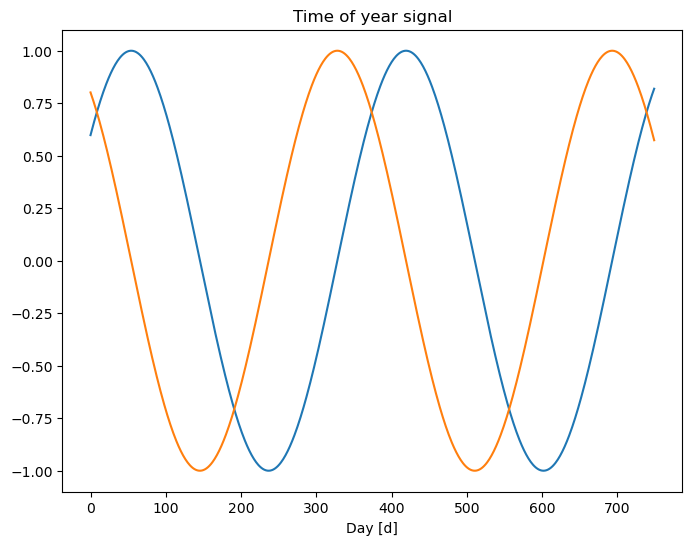

In [13]:
plt.plot(np.array(df['year_sin'])[:750])
plt.plot(np.array(df['year_cos'])[:750])
plt.xlabel('Day [d]')
plt.title('Time of year signal')
plt.show()

## Splitting the Data

We'll split the data as follows:
- Training: 2006-02-07 through 2014-02-06
- Validation: 2014-02-07 through 2016-02-06
- Testing: 2016-02-06 through 2017-09-28

Note: Here, the terminoligy is a little different than what we've been using in the boot camp course. The "validation" set is what we've been calling the "test" set, and the "testing" set is what we've been calling the "holdout" set. We adopt this convention just to make following the tutorial a little easier.

In [14]:
## Training
#date_time[:2922]
## Validation
#date_time[2922:3651]
## Testing
#date_time[3651:]
train_df = df[:2922].copy()
val_df = df[2922:3651].copy()
test_df = df[3651:].copy()

num_features = df.shape[1]

## Normalize the data

Here, we normalize the data using the mean and standard deviation from the training set (to avoid data leakage).

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Visualizing the normalized data

We'll visualize the normalized data to check for "obvious" errors.

/var/folders/kb/spl5dfb16tscp1by76mk_12c0000gn/T/ipykernel_37834/3214313372.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


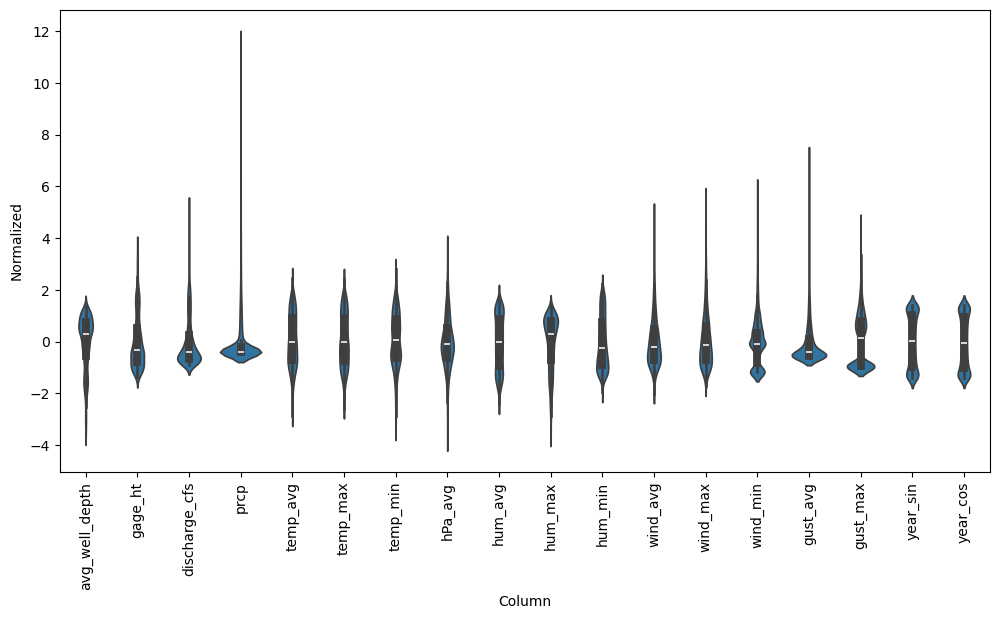

In [16]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

There are some long tails, but nothing too wild.

## Data Windowing

To keep things in line with the tutorial, we'll mimick their strategy for constructing data windows. This allows us to define:
- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

We're borrowing this code from the tutorial, with some slight modifications to fit our dataset, so that we can take advantage of all the functions and properties.

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [18]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [19]:
def plot(self, model=None, plot_col='avg_well_depth', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k',
                    linewidth=0.1,
                    label='Labels', 
                    c='#2ca02c', 
                    alpha =.6,
                    s=16)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X',
                      edgecolors='k',
                      linewidth=0.1,
                      label='Predictions',
                      c='#ff7f0e', 
                      alpha =.6,
                      s=16)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

In [20]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Building a multi-step model

We want to make predictions for the next year of data, or the next 365 steps. So we need a multi-step model. We're skipping to [https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models](here) in the tutorial.

First, we create a window that takes 365 steps as inputs, and sets 365 steps as targets.

Total window size: 730
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

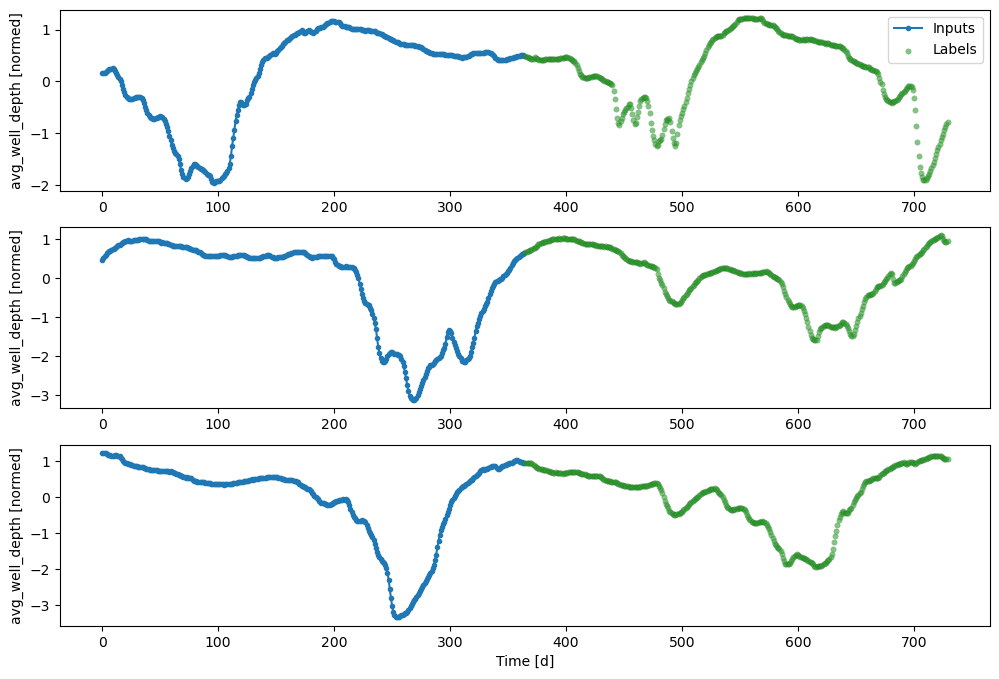

In [22]:
OUT_STEPS = 365
IN_WIDTH = 365
multi_window = WindowGenerator(input_width=IN_WIDTH,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, 
                               label_columns=['avg_well_depth'])

multi_window.plot()
multi_window

### Building a baseline model

We need to establish a baseline model, so that we have something to compare to our models.

#### Last Value Prediction
One example of a baseline model is to simply use the last value of the last training input as the prediction for future output values.

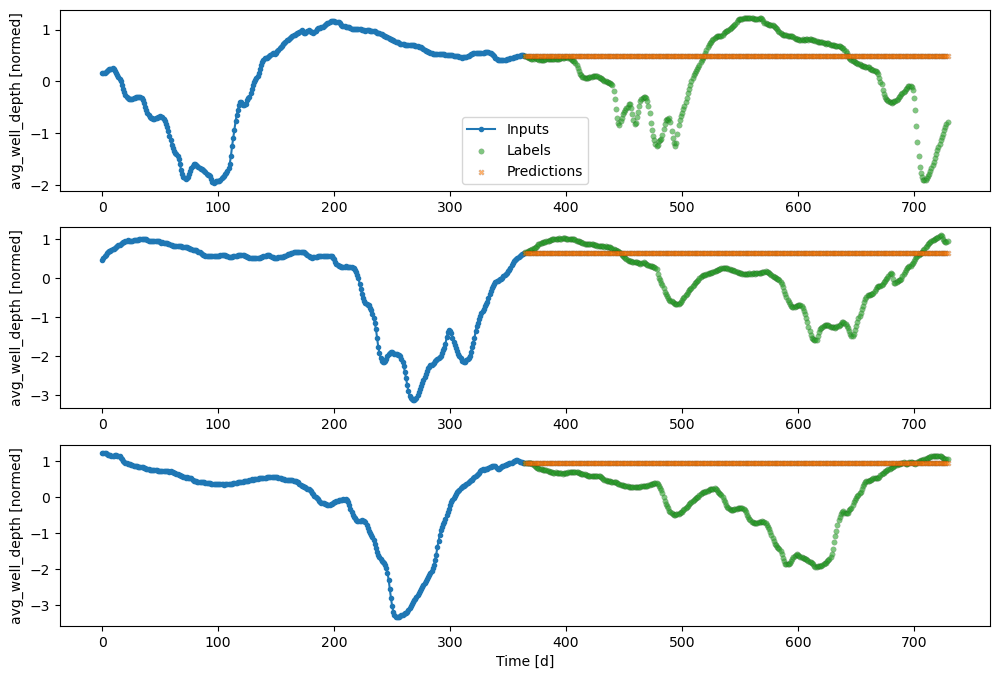

In [23]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

#### Last Year Prediction

Since our data is periodic, we can predict the value of a future output to be the output from one year prior.

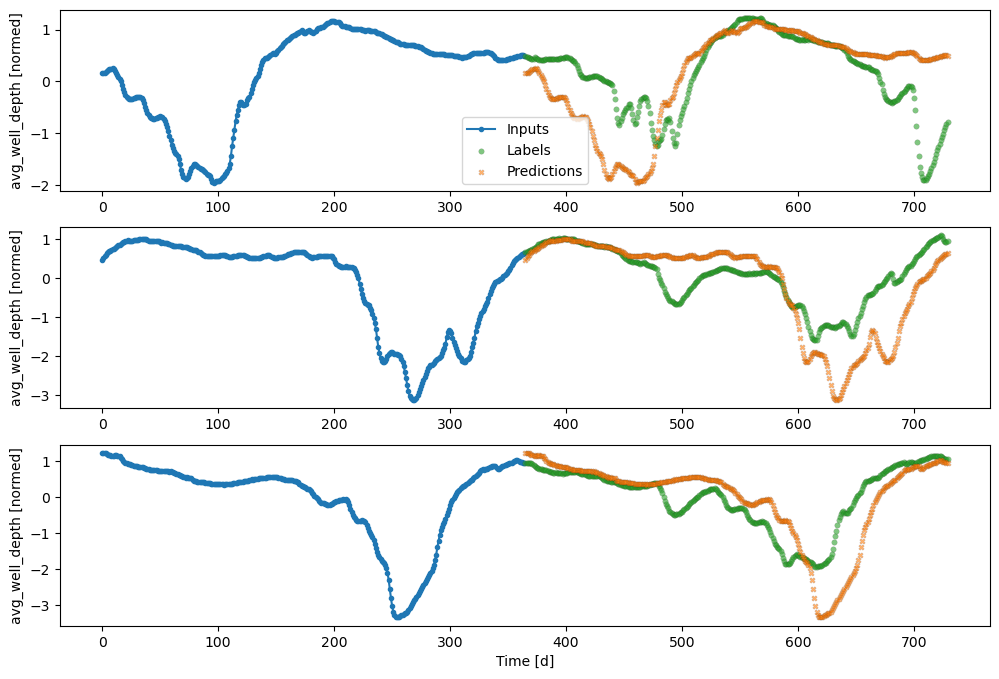

In [24]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, verbose=0)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single Shot Models

These models will predict the entire next year in a single step.

#### Linear

This produces a linear model based on the last input time step. The model needs to predict a full year of time steps, from a single input time step with a linear projection.

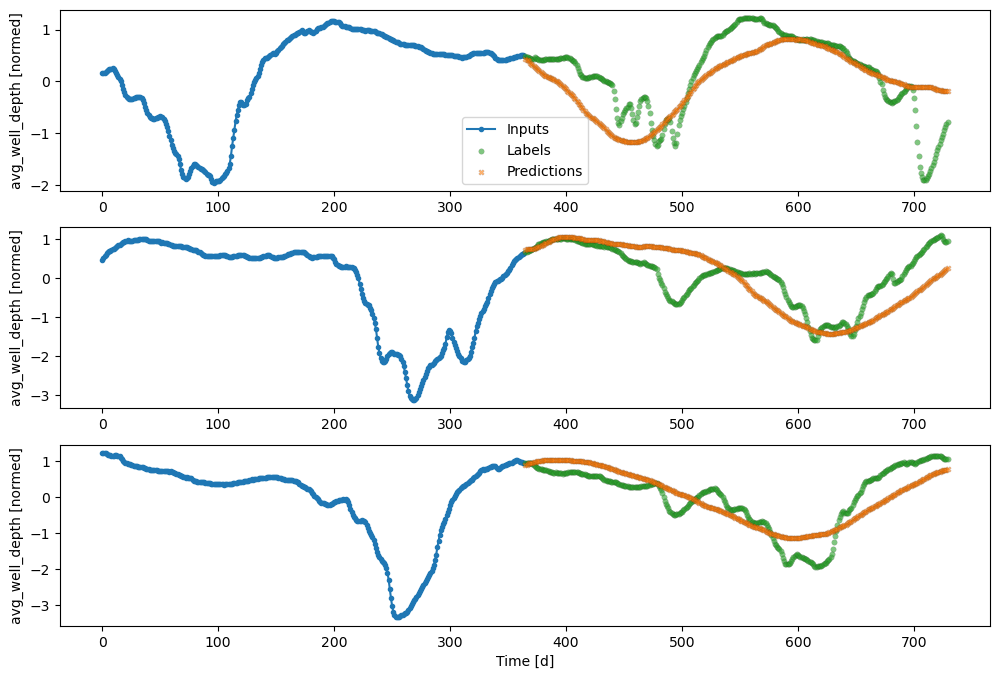

In [47]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, verbose=0)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Similar to the linear model, but with an additional dense layer between the input and output layers.

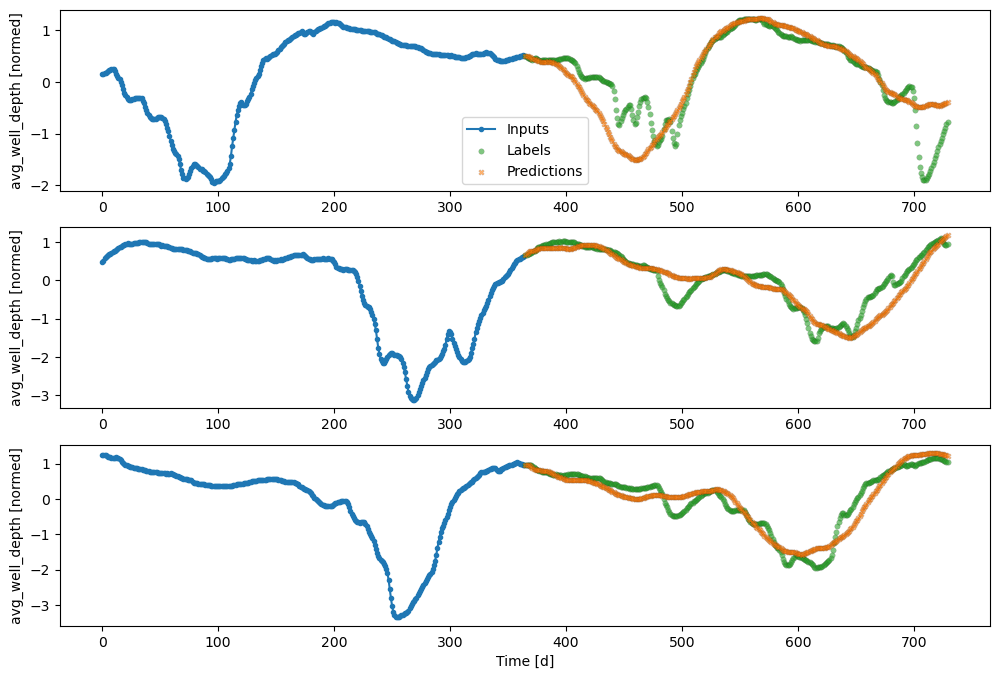

In [28]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, verbose=0)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

This convolutional model makes predictions based on a fixed-width history, rather than just a sinle time step.

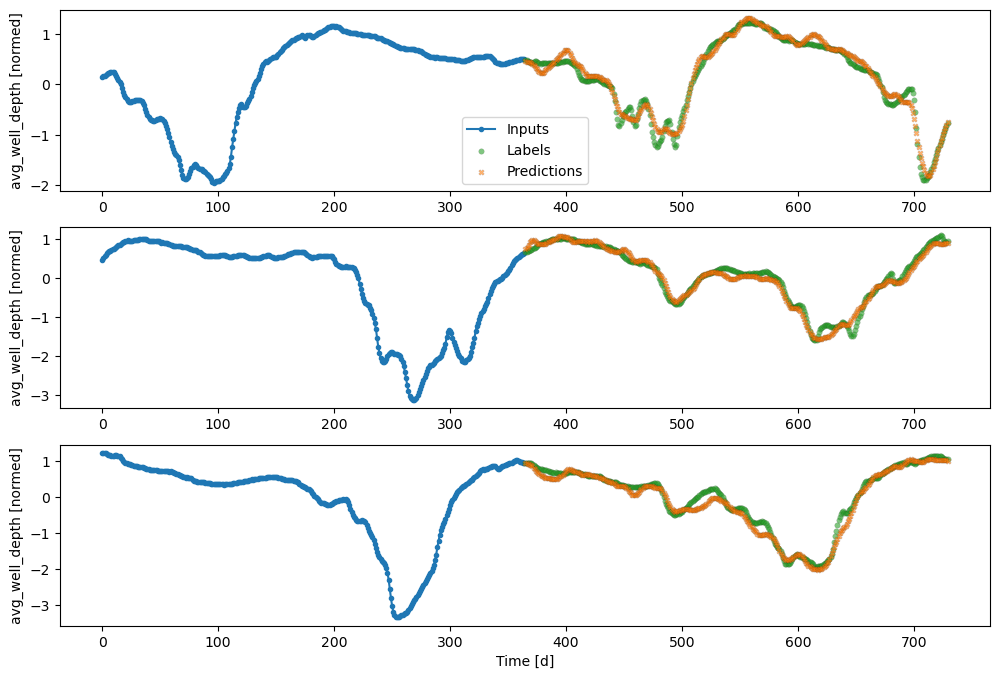

In [34]:
CONV_WIDTH = 60

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, verbose=0)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

This reccurent model will use a full year of history to make its predictions. With `return_sequences=False` it is still a single shot model.

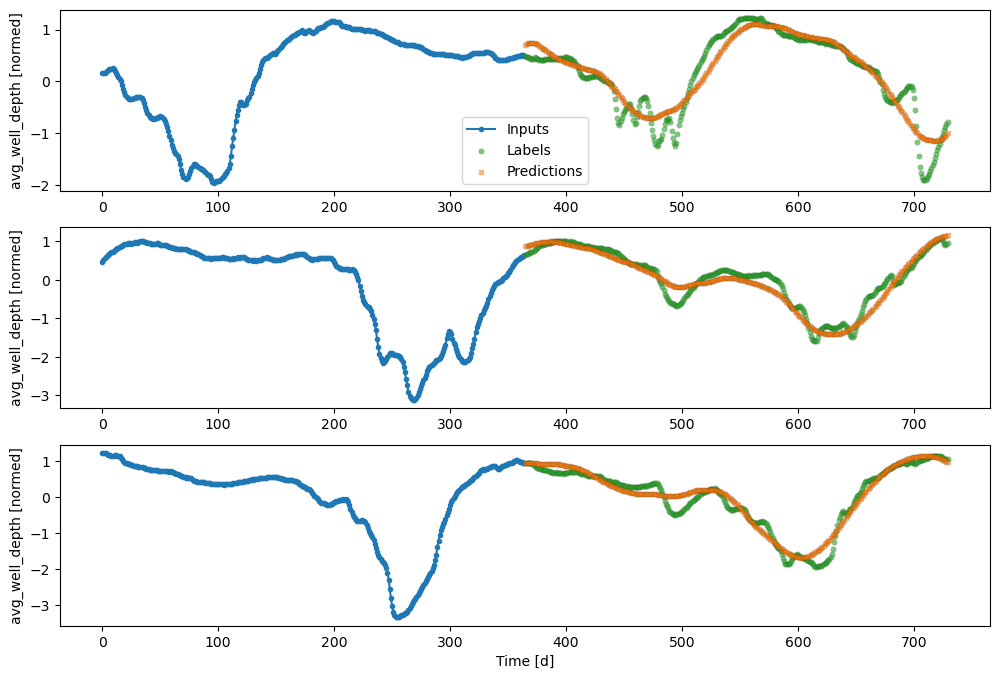

In [36]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, verbose=0)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

#### Autoregressive RNN

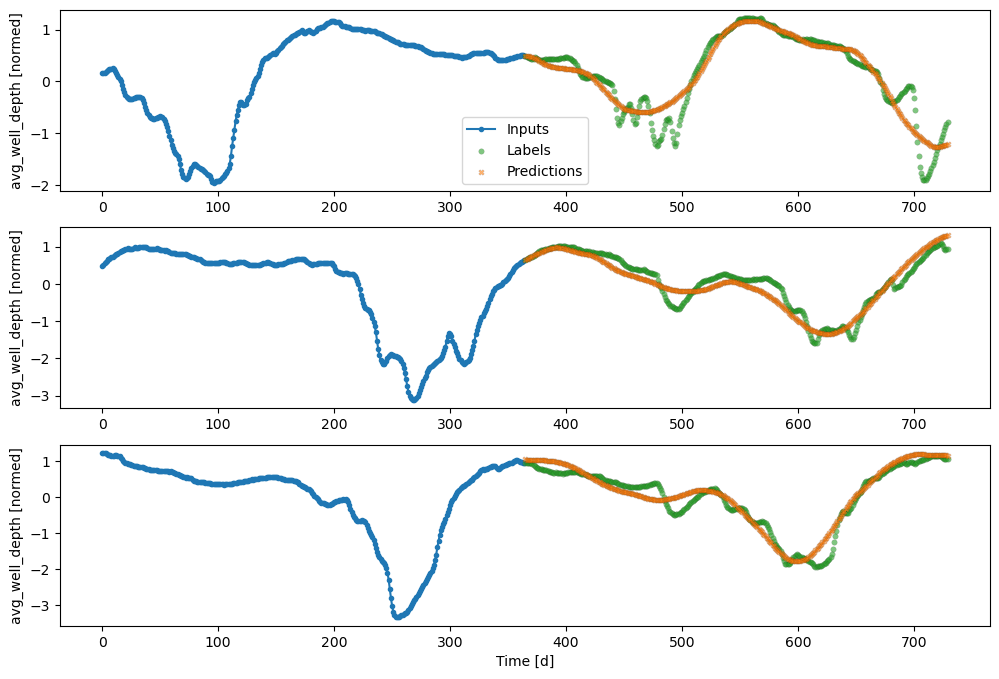

In [39]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, verbose=0)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [41]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [42]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [43]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 18])

In [44]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [45]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 365, 18)


In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose=0)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

Epoch 1/20


2023-11-01 17:45:32.088800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - ETA: 0s - loss: 1.0533 - mean_absolute_error: 0.8175  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error


69/69 [==============================] - 8652s 123s/step - loss: 1.0533 - mean_absolute_error: 0.8175
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 1.0152 - mean_absolute_error: 0.8007  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error


69/69 [==============================] - 7962s 115s/step - loss: 1.0152 - mean_absolute_error: 0.8007
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 1.0054 - mean_absolute_error: 0.7953  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error


69/69 [==============================] - 8063s 117s/step - loss: 1.0054 - mean_absolute_error: 0.7953
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 0.9795 - mean_absolute_error: 0.7860  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error


69/69 [==============================] - 8100s 117s/step - loss: 0.9795 - mean_absolute_error: 0.7860
Epoch 5/20
69/69 [==============================] - ETA: 0s - loss: 0.9707 - mean_absolute_error: 0.7732  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error


69/69 [==============================] - 8089s 117s/step - loss: 0.9707 - mean_absolute_error: 0.7732
Epoch 6/20
69/69 [==============================] - ETA: 0s - loss: 1.0461 - mean_absolute_error: 0.8097  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error


69/69 [==============================] - 7861s 114s/step - loss: 1.0461 - mean_absolute_error: 0.8097
Epoch 7/20
39/69 [===============>..............] - ETA: 1:10:28 - loss: 1.0285 - mean_absolute_error: 0.8099

### Performance

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()